# Predicting house prices

The goal is to develop regression models to predict house prices based on their characteristics.

# Scope
* The regression models developed will not be used to extrapolate beyond the range of the avaialble data. Instead predictions will be made for a holdout test set.

## About the data
* The dataset has been downloaded from [Kaggle](https://www.kaggle.com/datasets/harlfoxem/housesalesprediction/data).
  
* The data is heterogeneous, it contains both numerical and categorical features.

* The price feature is the target. All other columns are feature vectors.

# Data exploration
* This phase will involve identification of missing values and duplicate records, calculation of summary statistics, visualisation of frequency distributions and assessment of dependence between variables.

## Dependencies

In [1]:
import sys
CONFIG_DIRECTORY = 'C:\\Users\\billy\\OneDrive\\Documents\\Python Scripts\\1. Portfolio\\house-price-regression\\house-price-regression'
if CONFIG_DIRECTORY not in sys.path:
    sys.path.insert(0, CONFIG_DIRECTORY)

import ast
import config
import datetime
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from IPython.display import display
from matplotlib import pyplot as plt
import warnings
plt.style.use('seaborn-v0_8-muted')

## Import data

In [2]:
raw_df = pd.read_csv(config.file_directory('raw') + 'kc_house_data.csv')
print(f"Number of records: {raw_df.shape[0]}")
print(f"Number of columns: {raw_df.shape[1]}")
raw_df.head()

Number of records: 21613
Number of columns: 21


id             date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  20141013T000000  221900.0         3       1.00         1180   
1  6414100192  20141209T000000  538000.0         3       2.25         2570   
2  5631500400  20150225T000000  180000.0         2       1.00          770   
3  2487200875  20141209T000000  604000.0         4       3.00         1960   
4  1954400510  20150218T000000  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0           0     0  ...      7        1180              0   
1      7242     2.0           0     0  ...      7        2170            400   
2     10000     1.0           0     0  ...      6         770              0   
3      5000     1.0           0     0  ...      7        1050            910   
4      8080     1.0           0     0  ...      8        1680              0   

   yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
0      1955             0    98178  47.5112 -122.257           1340   
1      1951          1991    98125  47.7210 -122.319           1690   
2      1933             0    98028  47.7379 -122.233           2720   
3      1965             0    98136  47.5208 -122.393           1360   
4      1987             0    98074  47.6168 -122.045           1800   

   sqft_lot15  
0        5650  
1        7639  
2        8062  
3        5000  
4        7503  

[5 rows x 21 columns]

## Data types
***Key observations***
* The data is heterogenous. Both numerical and categorical variables are present.

* By default, the boolean *waterfront* variable has been imported as a numerical data type. To simplify later analyses, it will be cast to the boolean data type. Similarly, the *id* and *zipcode* variables are cast to the object data type and the *date* variable to the datetime data type.

In [3]:
raw_df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [4]:
raw_df.dtypes.value_counts()

int64      15
float64     5
object      1
Name: count, dtype: int64

In [5]:
raw_df['date'] = pd.to_datetime(raw_df['date'], format='%Y%m%dT000000')
raw_df[['id', 'zipcode']] = raw_df[['id', 'zipcode']].astype(object)
raw_df['waterfront'] = raw_df['waterfront'].astype('bool')
raw_df.dtypes.value_counts()

int64             12
float64            5
object             2
datetime64[ns]     1
bool               1
Name: count, dtype: int64

## Missing values
***Key observations***
* No missing values are present.

In [6]:
raw_df.isnull().sum()[(raw_df.isnull().sum() > 1)]

Series([], dtype: int64)

## Duplicate records
***Key observations***
* No duplicate records are present.

In [7]:
raw_df[raw_df.duplicated()]

Empty DataFrame
Columns: [id, date, price, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15]
Index: []

[0 rows x 21 columns]

## Frequency distributions
***Key observations***
* Features are segmented by variable type in the below analysis.

### Date variables
* Date variables are distinguished by level of measurement below. Where, the *date* feature is classed as an interval variable and the *yr_built* and *yr_renovated* variables as ordinal.

#### Interval
* [Interval data is measured along a numerical scale that has equal distances between adjacent values. These distances are called ‘intervals’. There is no true zero on an interval scale, which is what distinguishes it from a ratio scale. On an interval scale, zero is an arbitrary point, not a complete absence of the variable.](https://www.scribbr.co.uk/stats/interval-data-meaning/)

***Key observations***
* The earliest and latest data points are 02-05-2014 and 27-05-2015. It is unclear whether data collection was occuring outside of these bounds.

* The distribution of points over the observed time period is reasonably uniform. However, less records are observed around Christmas (December/January) and on the weekend.

In [8]:
raw_df[['date']].describe()

date
count                          21613
mean   2014-10-29 04:38:01.959931648
min              2014-05-02 00:00:00
25%              2014-07-22 00:00:00
50%              2014-10-16 00:00:00
75%              2015-02-17 00:00:00
max              2015-05-27 00:00:00

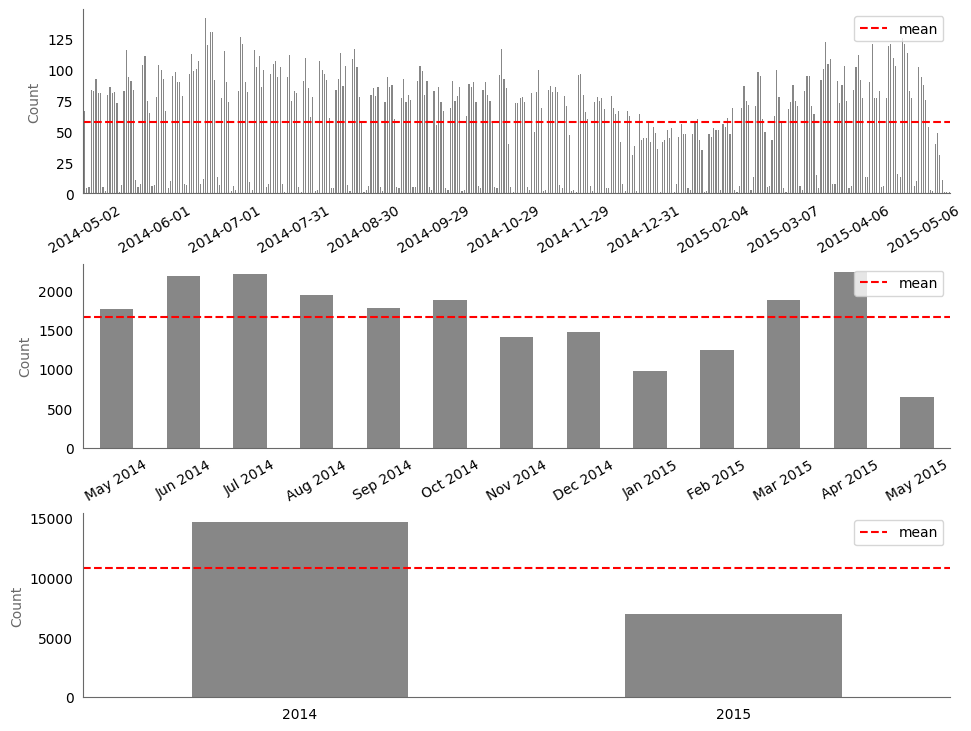

In [9]:
# Calc per day/month/year
per_day = raw_df['date'].groupby(raw_df['date']).count()
per_month = raw_df['date'].groupby([raw_df['date'].dt.year, raw_df['date'].dt.month]).count()
per_year = raw_df['date'].groupby(raw_df['date'].dt.year).count()

# Plot per day
fig, axes = plt.subplots(nrows=3, ncols=1, constrained_layout=True, figsize=(6.4*1.5, 4.8*1.5))
per_day.plot.bar(ax=axes[0], color='dimgray', alpha=0.8, label='')
axes[0].axhline(per_day.mean(), linestyle='--', color='red', label='mean')
xtick_labels = axes[0].get_xticklabels()[::30]
xtick_positions = [x.get_position()[0] for x in xtick_labels]
xtick_labels = [x.get_text()[:10] for x in xtick_labels]
axes[0].set_xticks(xtick_positions, xtick_labels)
axes[0].set_xticklabels(xtick_labels, rotation=30)

# Plot per year/month
per_month.plot.bar(ax=axes[1], color='dimgray', alpha=0.8, label='')
axes[1].axhline(per_month.mean(), linestyle='--', color='red', label='mean')
xtick_labels = [item.get_text() for item in axes[1].get_xticklabels()]
xtick_labels = [ast.literal_eval(label) for label in xtick_labels]
dates = {1:'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
xtick_labels = [dates[label[1]] + " " + str(label[0]) for label in xtick_labels]
axes[1].set_xticklabels(xtick_labels, rotation=30);

# Plot per year
per_year.plot.bar(ax=axes[2], color='dimgray', alpha=0.8, label='')
axes[2].axhline(per_year.mean(), linestyle='--', color='red', label='mean')
xtick_labels = [item.get_text() for item in axes[2].get_xticklabels()]
axes[2].set_xticklabels(xtick_labels, rotation=0);

for ax in axes:
    ax.legend(loc='upper right');
    ax.set_xlabel('')
    ax.set_ylabel('Count', fontsize=10, color='dimgray')
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

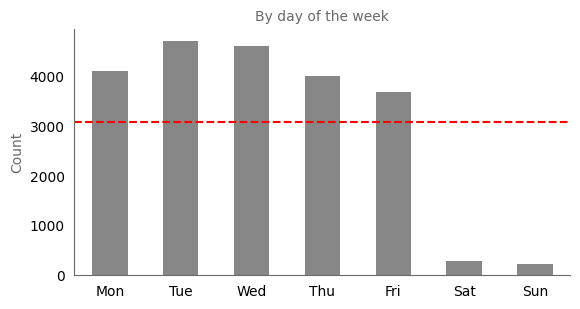

In [10]:
fig, axes = plt.subplots(figsize=(6.4, 4.8/1.5))
axes.tick_params(bottom=False, left=False, rotation=0)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

by_dayofweek = raw_df['date'].groupby(raw_df['date'].dt.dayofweek).count()
by_dayofweek.plot.bar(ax=axes, color='dimgray', alpha=0.8, label='')
axes.axhline(by_dayofweek.mean(), linestyle='--', color='red', label='mean')
xtick_positions = [0, 1, 2, 3, 4, 5, 6]
xtick_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes.set_xticks(xtick_positions, xtick_labels, rotation=0)
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.set_xlabel('')
axes.set_title('By day of the week', fontsize=10, color='dimgray');

#### Ordinal
* [Ordinal data is classified into categories within a variable that have a natural rank order. However, the distances between the categories are uneven or unknown.](https://www.scribbr.co.uk/stats/ordinal-data-meaning/)

***Key observations***
* The frequency of houses built increases over time.
  
* The *yr_renovated* feature indicates the majority of houses have not been renovated (95.8%). A boolean feature *yr_renovated_bool* has been created to distinguish those which have been renovated.

* The frequency of renovations increases over time.

In [11]:
ordinal_dates = ['yr_built', 'yr_renovated']
raw_df[ordinal_dates].describe()

yr_built  yr_renovated
count  21613.000000  21613.000000
mean    1971.005136     84.402258
std       29.373411    401.679240
min     1900.000000      0.000000
25%     1951.000000      0.000000
50%     1975.000000      0.000000
75%     1997.000000      0.000000
max     2015.000000   2015.000000

In [12]:
from custom_funcs import perc_func
raw_df['yr_renovated_bool'] = raw_df['yr_renovated'].apply(lambda x: 1 if x>0 else 0)
perc_func(raw_df, 'yr_renovated_bool')

count  perc
yr_renovated_bool             
0                  20699  95.8
1                    914   4.2

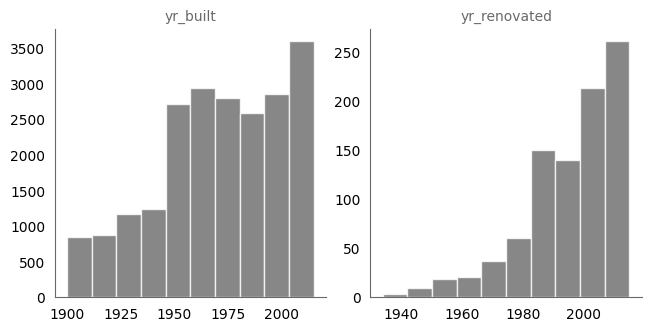

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(6.4, 4.8/1.5))
axes = axes.flatten()
for ax, col in zip(axes, ordinal_dates):
    if col == 'yr_renovated':
        bars = ax.hist(raw_df.loc[raw_df['yr_renovated_bool']==1, col], color='dimgray', alpha=0.8, edgecolor ="white")
    else:
        bars = ax.hist(raw_df[col], color='dimgray', alpha=0.8, edgecolor ="white")
    ax.set_title(f"{col}", fontsize=10, color='dimgray')
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

### Categorical variables
* [Categorical variables represent groupings of some kind](https://www.scribbr.co.uk/research-methods/variables-types/).

* Categorical features are distinguished by level of measurement below (i.e. nominal/ordinal).

#### Nominal
* [Nominal data is labelled into mutually exclusive categories within a variable. These categories cannot be ordered in a meaningful way.](https://www.scribbr.co.uk/stats/nominal-data-meaning/)

***Key observations***
* The cardinality of the *id* feature indicates the presence of duplicate ids. However, these records correspond to distinct houses.

* Houses are distributed across 70 zip codes.

In [14]:
print(f"Number of records: {raw_df.shape[0]}")

Number of records: 21613


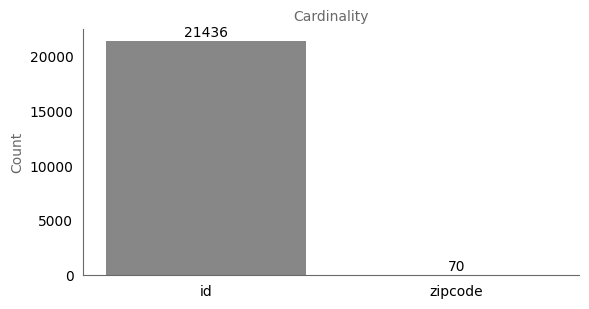

In [15]:
fig, axes = plt.subplots(figsize=(6.4, 4.8/1.5))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

object_nunique = raw_df.select_dtypes(include=object).nunique()
bars = axes.bar(object_nunique.index, object_nunique.values, color='dimgray', alpha=0.8)
axes.bar_label(bars, padding=1);
axes.set_ylabel('Count', fontsize=10, color='dimgray')
axes.set_title('Cardinality', fontsize=10, color='dimgray');

In [16]:
raw_df[raw_df.duplicated('id')].head()

id       date      price  bedrooms  bathrooms  sqft_living  \
94   6021501535 2014-12-23   700000.0         3       1.50         1580   
314  4139480200 2014-12-09  1400000.0         4       3.25         4290   
325  7520000520 2015-03-11   240500.0         2       1.00         1240   
346  3969300030 2014-12-29   239900.0         4       1.00         1000   
372  2231500030 2015-03-24   530000.0         4       2.25         2180   

     sqft_lot  floors  waterfront  view  ...  sqft_above  sqft_basement  \
94       5000     1.0       False     0  ...        1290            290   
314     12103     1.0       False     3  ...        2690           1600   
325     12092     1.0       False     0  ...         960            280   
346      7134     1.0       False     0  ...        1000              0   
372     10754     1.0       False     0  ...        1100           1080   

     yr_built  yr_renovated  zipcode      lat     long  sqft_living15  \
94       1939             0    98117  47.6870 -122.386           1570   
314      1997             0    98006  47.5503 -122.102           3860   
325      1922          1984    98146  47.4957 -122.352           1820   
346      1943             0    98178  47.4897 -122.240           1020   
372      1954             0    98133  47.7711 -122.341           1810   

     sqft_lot15  yr_renovated_bool  
94         4500                  0  
314       11244                  0  
325        7460                  1  
346        7138                  0  
372        6929                  0  

[5 rows x 22 columns]

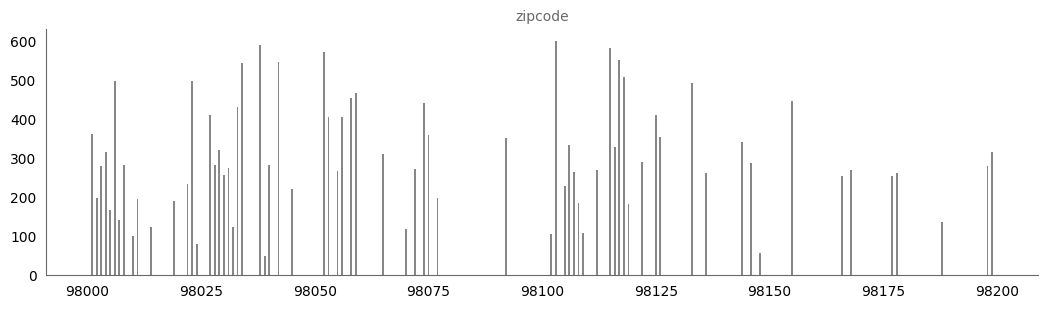

In [17]:
fig, axes = plt.subplots(figsize=(6.4*2, 4.8/1.5))
axes.tick_params(bottom=False, left=False)
axes.grid(False)
axes.spines[['top', 'right']].set_visible(False)
axes.spines[['left', 'bottom']].set_color('dimgray')

freq = perc_func(raw_df, 'zipcode')
freq = freq.sort_index()
bars = axes.bar(freq.index, freq['count'], color='dimgray', alpha=0.8, width=0.4)
axes.set_title(f"{'zipcode'}", fontsize=10, color='dimgray');

#### Ordinal
* [Ordinal data is classified into categories within a variable that have a natural rank order. However, the distances between the categories are uneven or unknown.](https://www.scribbr.co.uk/stats/ordinal-data-meaning/)

***Key observations***

In [18]:
ordinal_cols = ['condition', 'grade']
raw_df[ordinal_cols].describe()

condition         grade
count  21613.000000  21613.000000
mean       3.409430      7.656873
std        0.650743      1.175459
min        1.000000      1.000000
25%        3.000000      7.000000
50%        3.000000      7.000000
75%        4.000000      8.000000
max        5.000000     13.000000

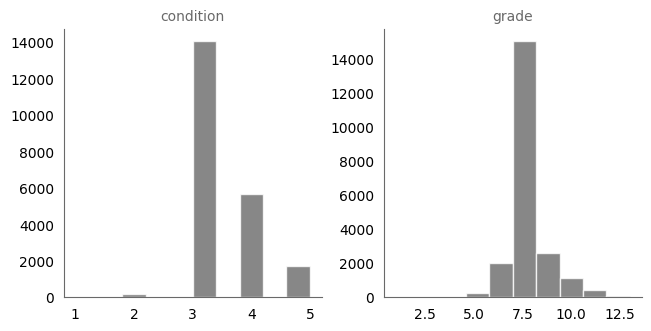

In [19]:
fig, axes = plt.subplots(
    nrows=1, ncols=2, constrained_layout=True, figsize=(6.4, 4.8/1.5))
axes = axes.flatten()
for ax, col in zip(axes, ordinal_cols):
    bars = ax.hist(raw_df[col], color='dimgray', alpha=0.8, edgecolor ="white")
    ax.set_title(f"{col}", fontsize=10, color='dimgray')
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

#### Boolean
***Key observations***
* For the *waterfront* feature, the majority of records are classified as No (99.2%).
* For the *yr_renovated_bool* feature, the majority of records are classified as No (95.8%).

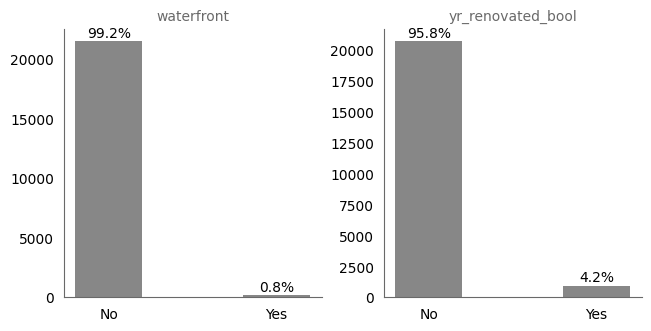

In [20]:
fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(6.4, 4.8/1.5))
axes = axes.flatten()
for ax in axes:
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')

for ax, col in zip(axes, ['waterfront', 'yr_renovated_bool']):
    freq = perc_func(raw_df, col)
    bar_labels = [str(x) + '%' for x in freq['perc'].values]
    bars = ax.bar(freq.index, freq['count'], color='dimgray', alpha=0.8, width=0.4)
    ax.bar_label(bars, bar_labels, padding=1)
    xtick_positions = [0, 1]
    xtick_labels = ['No', 'Yes']
    ax.set_xticks(xtick_positions, xtick_labels)
    ax.set_title(f"{col}", fontsize=10, color='dimgray');

### Quantitative variables
* Quantitative features are distinguished by level of measurement below (i.e. ratio/interval).

#### Ratio
* [A ratio scale is a quantitative scale where there is a true zero and equal intervals between neighbouring points. Unlike on an interval scale, a zero on a ratio scale means there is a total absence of the variable you are measuring.](https://www.scribbr.co.uk/stats/ratio-data-meaning/)

***Key observations***
* All variables are non-normal.

* The following variables are discrete and therefore non-normal: *bathrooms, bedrooms, floors and view*.

* The following variables are continuous and their distributions are skewed: *sqft_above, sqft_basement, sqft_living, sqft_living15*

* Outliers appear to be present in the following columns: *price, sqft_above, sqft_basement, sqft_living, sqft_lot, sqft_lot15*

In [21]:
ratio_cols = ['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
              'floors', 'view', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']
ratio_cols.sort()
raw_df[ratio_cols].describe()

bathrooms      bedrooms        floors         price    sqft_above  \
count  21613.000000  21613.000000  21613.000000  2.161300e+04  21613.000000   
mean       2.114757      3.370842      1.494309  5.400881e+05   1788.390691   
std        0.770163      0.930062      0.539989  3.671272e+05    828.090978   
min        0.000000      0.000000      1.000000  7.500000e+04    290.000000   
25%        1.750000      3.000000      1.000000  3.219500e+05   1190.000000   
50%        2.250000      3.000000      1.500000  4.500000e+05   1560.000000   
75%        2.500000      4.000000      2.000000  6.450000e+05   2210.000000   
max        8.000000     33.000000      3.500000  7.700000e+06   9410.000000   

       sqft_basement   sqft_living  sqft_living15      sqft_lot  \
count   21613.000000  21613.000000   21613.000000  2.161300e+04   
mean      291.509045   2079.899736    1986.552492  1.510697e+04   
std       442.575043    918.440897     685.391304  4.142051e+04   
min         0.000000    290.000000     399.000000  5.200000e+02   
25%         0.000000   1427.000000    1490.000000  5.040000e+03   
50%         0.000000   1910.000000    1840.000000  7.618000e+03   
75%       560.000000   2550.000000    2360.000000  1.068800e+04   
max      4820.000000  13540.000000    6210.000000  1.651359e+06   

          sqft_lot15          view  
count   21613.000000  21613.000000  
mean    12768.455652      0.234303  
std     27304.179631      0.766318  
min       651.000000      0.000000  
25%      5100.000000      0.000000  
50%      7620.000000      0.000000  
75%     10083.000000      0.000000  
max    871200.000000      4.000000

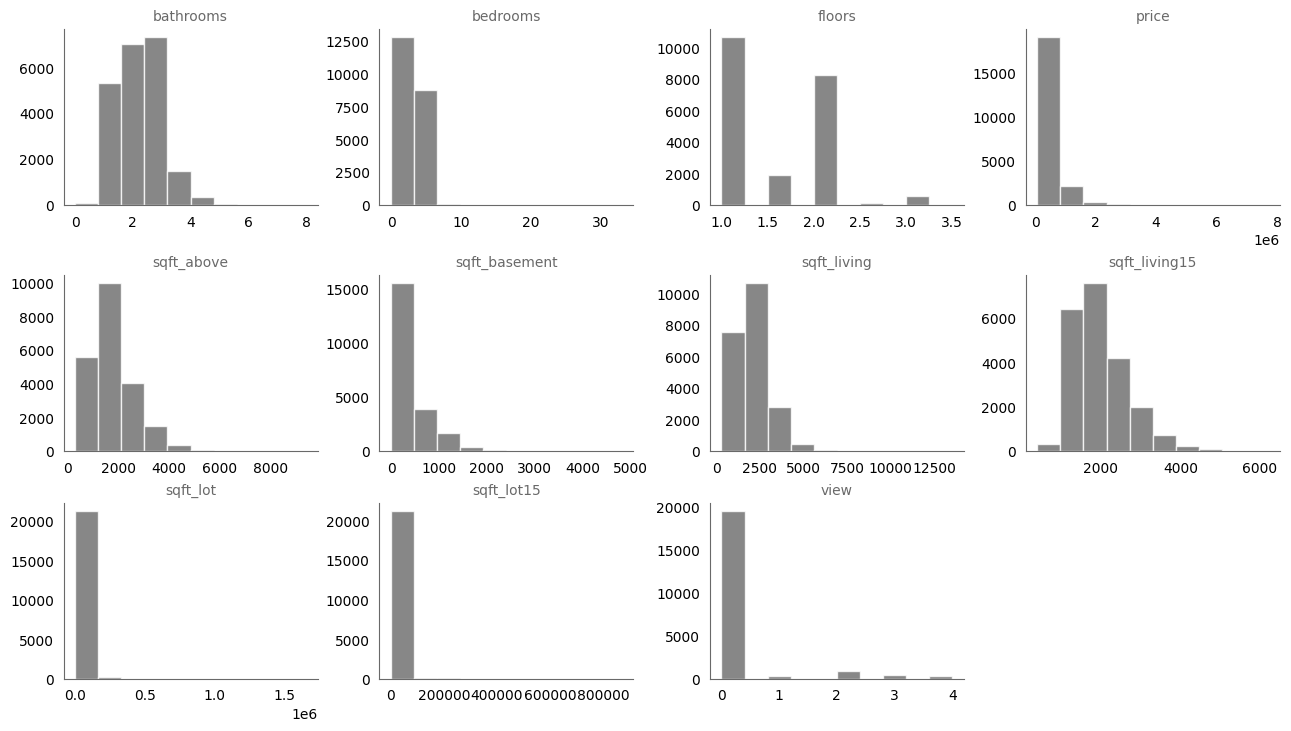

In [22]:
fig, axes = plt.subplots(
    nrows=3, ncols=4, constrained_layout=True, figsize=(6.4*2, 4.8*1.5))
axes = axes.flatten()
for ax, col in zip(axes, ratio_cols):
    bars = ax.hist(raw_df[col], color='dimgray', alpha=0.8, edgecolor ="white")
    ax.set_title(f"{col}", fontsize=10, color='dimgray')
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.delaxes(axes[11])

#### Interval
* [Interval data is measured along a numerical scale that has equal distances between adjacent values. These distances are called ‘intervals’. There is no true zero on an interval scale, which is what distinguishes it from a ratio scale. On an interval scale, zero is an arbitrary point, not a complete absence of the variable.](https://www.scribbr.co.uk/stats/interval-data-meaning/)

***Key observations***
* No interval variables are present.

## Correlation

### Numerical-numerical

***Key observations***

* A matrix of scatter plots was used to visualise dependencies between numerical features. Non-linear dependencies are observed.

* Spearman's rank was used to assess the relationship between numerical variables. It gives a correlation coefficient between -1 and 1. It is a non-parametric test, meaning it does not assume any underlying data distribution and it can be used to assess non-linear relationships. Both factors are crucial given the non-linear associations and non-normal distributions observed.

* Price appears to be positively correlated with the following features: *bathrooms, grade, sqft_living and sqft_living15*

* Many of the predictors are correlated (e.g. bathrooms-floors, bathrooms-grade)

In [23]:
# Convert timestamp object to integer
raw_df['date_int'] = pd.to_numeric(raw_df['date'])

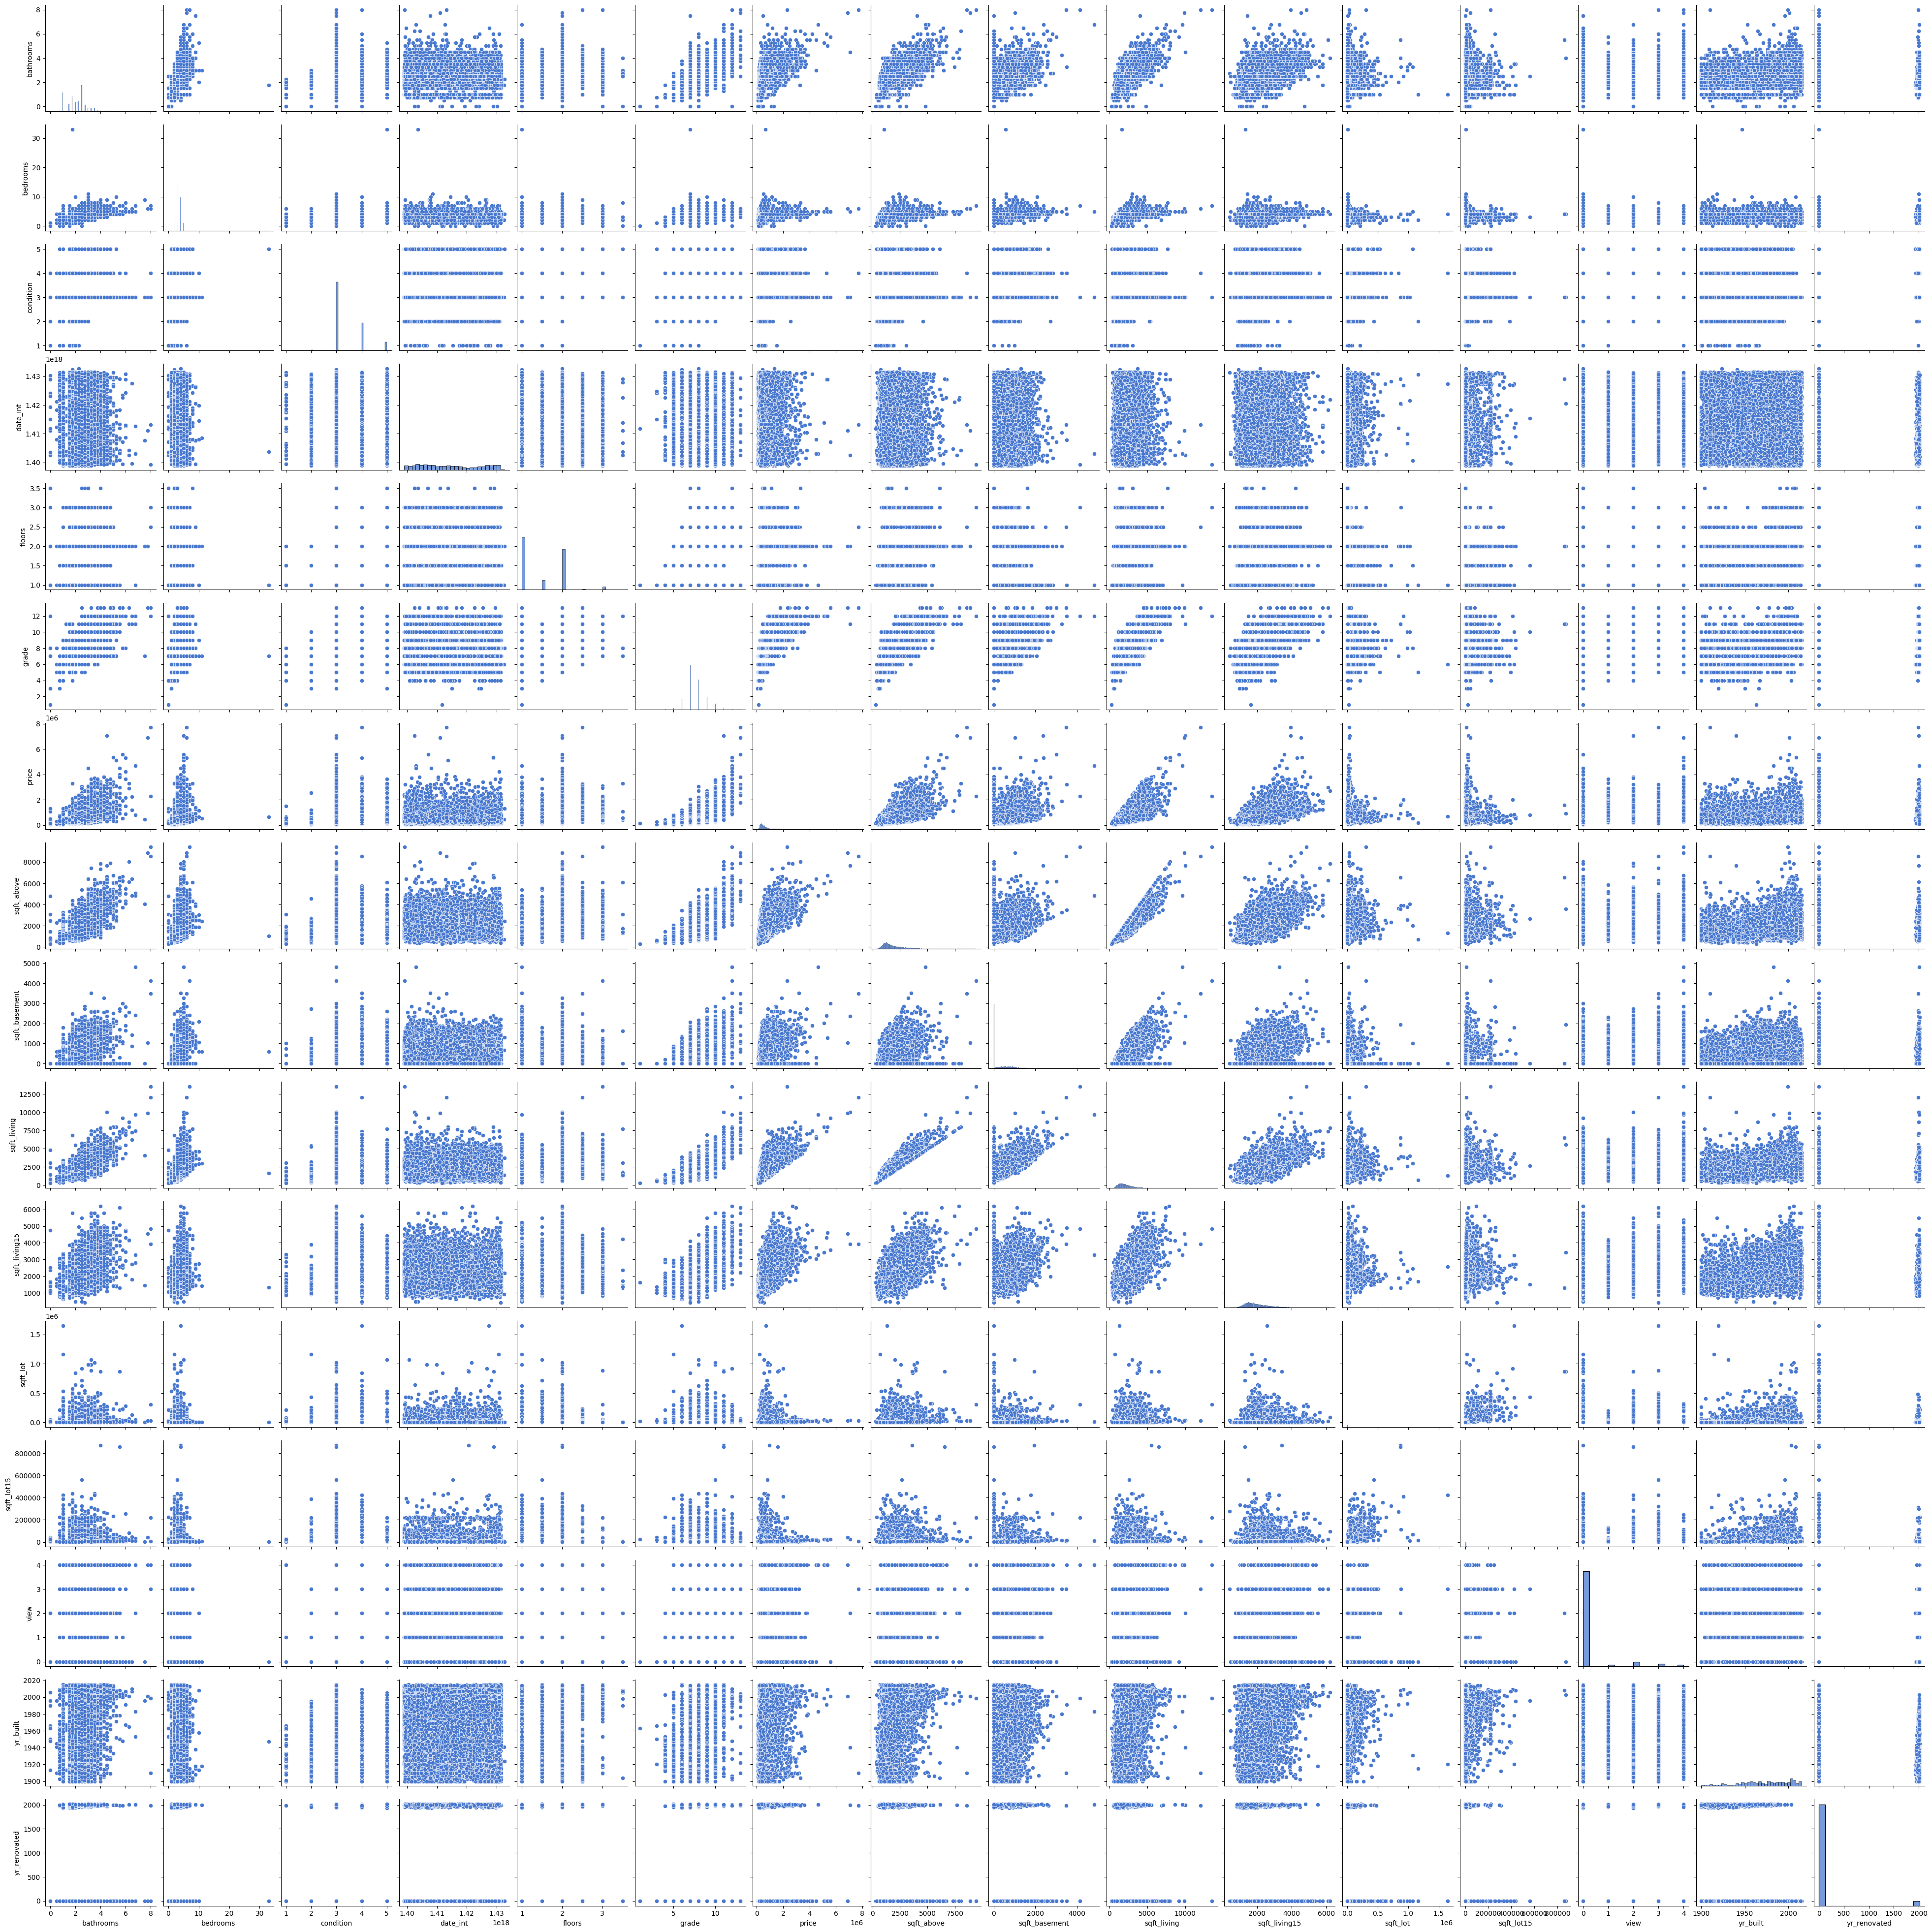

In [24]:
# Matrix of scatter plots
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

num_cols = ordinal_cols + ratio_cols + ordinal_dates
num_cols.append('date_int')
num_cols.sort()
sns.pairplot(raw_df[num_cols])

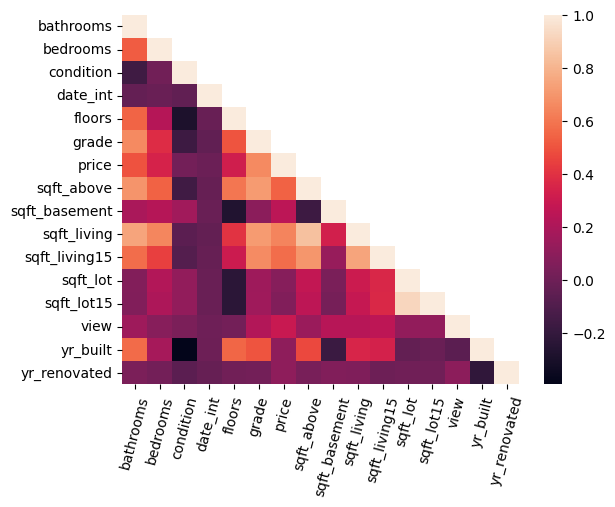

In [25]:
spearmans_corr = raw_df[num_cols].corr(method='spearman')
num_mask = np.tril(spearmans_corr) == 0

fig, axes = plt.subplots(figsize=(6.4, 4.8))
sns.heatmap(spearmans_corr, mask=num_mask, ax=axes)
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
axes.set_xticklabels(xtick_labels, rotation=75);

### Categorical-categorical

* Cramer's V was used to assess bivariate associations between nominal variables. This is a non-parametric test, meaning it does not assume any underlying data distribution. It gives a value between 0 and +1.

***Key observations***

* No correlation is observed between waterfront and zipcode.

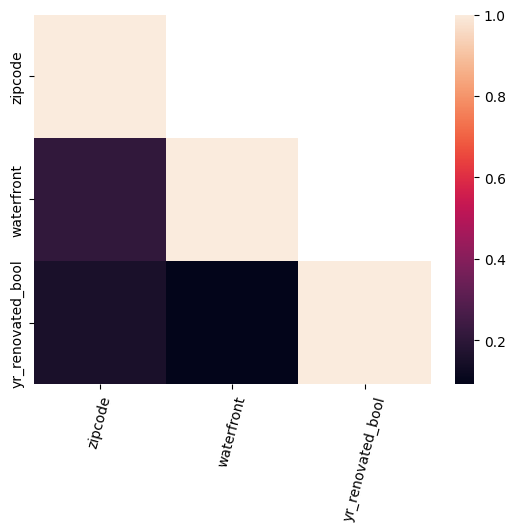

In [26]:
from custom_funcs import cramers_v

object_cols = ['zipcode', 'waterfront', 'yr_renovated_bool']

cramersv_corr = pd.DataFrame([[(row, col) for row in object_cols]
                        for col in object_cols], columns=object_cols, index=object_cols)
cramersv_corr = cramersv_corr.map(lambda x: cramers_v(x, df=raw_df))
cat_mask = np.tril(cramersv_corr) == 0

fig, axes = plt.subplots(figsize=(6.4, 4.8))
sns.heatmap(cramersv_corr, mask=cat_mask, ax=axes)
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
axes.set_xticklabels(xtick_labels, rotation=75);

### Categorical-numerical

* One way ANOVA was used to assess the relationship between categorical and numerical variables. This determines the statistical significance of any differences in the mean of the numerical variable across different categories.

***Key observations***
* All numerical variables appear to be significantly different depending on zip code.

* All numerical variables other than *bedrooms* appear to be significantly different when a property has a waterfront.

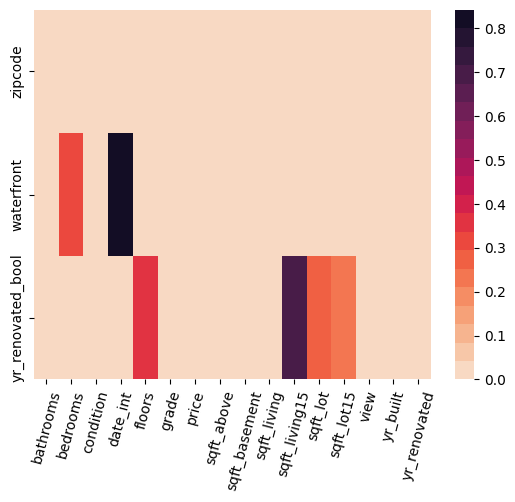

In [27]:
from scipy.stats import f_oneway
from custom_funcs import oneway_anova

anova_corr = pd.DataFrame([[(row, col) for col in num_cols]
                        for row in object_cols], columns=num_cols, index=object_cols)
anova_corr = anova_corr.map(lambda x: oneway_anova(x, df=raw_df))

fig, axes = plt.subplots(figsize=(6.4, 4.8))
sns.heatmap(anova_corr, ax=axes, cmap=sns.color_palette("rocket_r", 20))
xtick_labels = [item.get_text() for item in axes.get_xticklabels()]
axes.set_xticklabels(xtick_labels, rotation=75);

# Data cleansing
***Key observations***
* No duplicate records are present in the data (duplicate ids correspond to different houses)

* No missing values are present in the data.

* Outlier(s) are present in many numerical variables. These will not be addressed until after assessment of initial predictive performance.

In [28]:
clean_df = raw_df.copy(deep=True)

# Feature engineering

## Drop unnecessary features
***Key observations***
* Dimensionality is reduced by dropping features which data exploration suggested have little value

In [29]:
clean_df = clean_df.drop(['date', 'date_int', 'lat', 'long', 'yr_renovated'], axis=1)

## Train/test split
***Key observations***
* All transformations are conducted after the train/test split.

In [41]:
from sklearn.model_selection import train_test_split
X = clean_df.iloc[:, clean_df.columns != 'price']
y = clean_df.iloc[:, clean_df.columns == 'price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=0)
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)
train_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

## Reduce cardinality
***Key observations***
* The cardinality of the zipcode variable will be reduced by grouping them according to average sale price.

In [44]:
# pd.qcut(train_df['price'], 4, labels = False)

## Quantile transformations
***Key observations***
* All numerical variables will be quantile transformed to a normal distribution.

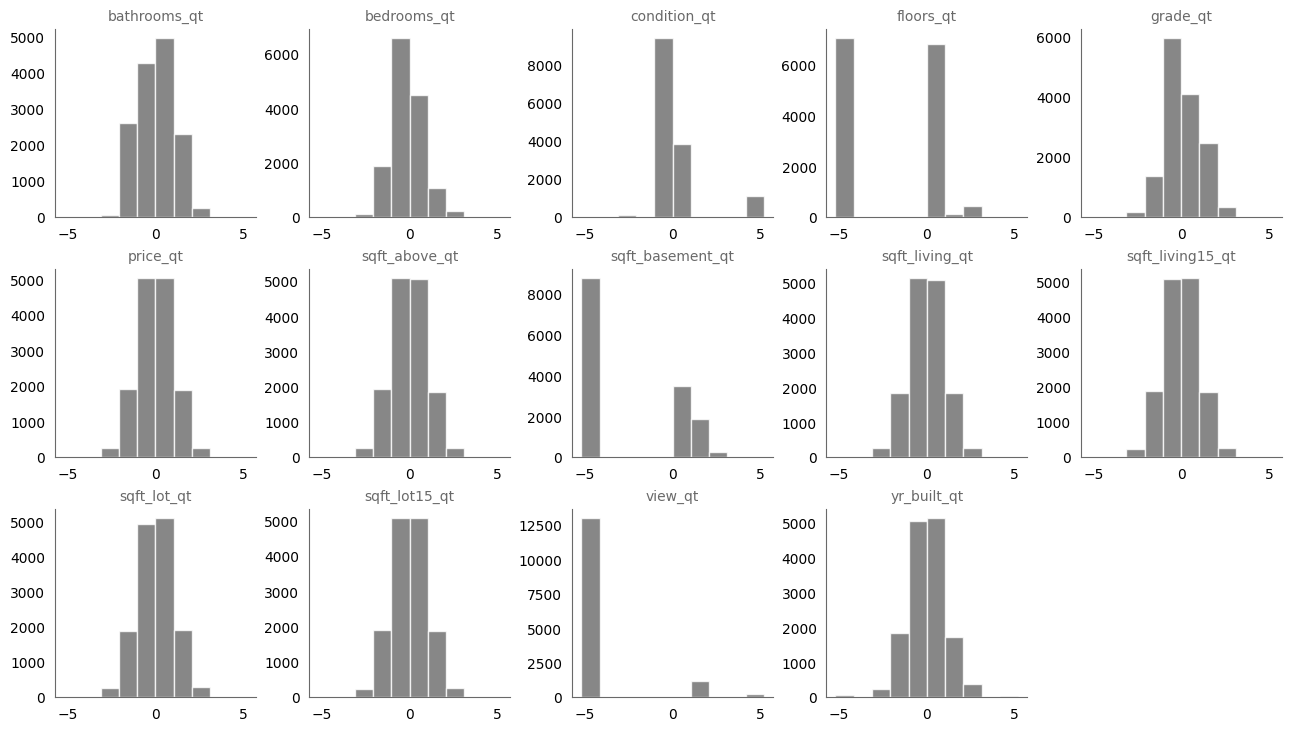

In [31]:
from sklearn.preprocessing import QuantileTransformer
num_cols = ['bathrooms', 'bedrooms', 'condition', 'floors', 'grade', 'price', 'sqft_above',
            'sqft_basement', 'sqft_living', 'sqft_living15', 'sqft_lot', 'sqft_lot15', 'view', 'yr_built']
qt = QuantileTransformer(output_distribution='normal')
q_features = qt.fit_transform(train_df[num_cols])
train_df = train_df.join(pd.DataFrame(
    q_features, columns=[c + '_qt' for c in num_cols]))
train_df = train_df.drop(num_cols, axis=1)

fig, axes = plt.subplots(nrows=3, ncols=5, constrained_layout=True, figsize=(6.4*2, 4.8*1.5))
axes = axes.flatten()
for ax, col in zip(axes, list(train_df.filter(regex='_qt', axis=1).columns)):
    bars = ax.hist(train_df[col], color='dimgray', alpha=0.8, edgecolor="white")
    ax.set_title(f"{col}", fontsize=10, color='dimgray')
    ax.tick_params(bottom=False, left=False)
    ax.grid(False)
    ax.spines[['top', 'right']].set_visible(False)
    ax.spines[['left', 'bottom']].set_color('dimgray')
fig.delaxes(axes[14])

## Encodings
* All boolean variables are label encoded (True=1, False=0).

In [32]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_cols = ['waterfront']
train_df[le_cols] = train_df[le_cols].apply(le.fit_transform)

# Export data

In [33]:
clean_df.to_csv(config.file_directory('cleaned') + 'cleaned_df.csv', index=False)
train_df.to_csv(config.file_directory('cleaned') + 'train_df.csv', index=False)